In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import time
import datetime
import re
import requests

print("Popular companies and their codes. But you can enter any publicly traded company.")
companies = ['Absa Group Limited','Forward Industries, Inc','Alphabet Inc','Microsoft']
codes = ['ABG.JO', 'TKG.JO','FORD','GOOG','MSFT' ]

for i in range(len(companies)):
    print(f"{companies[i]:<25}{codes[i]}")
    

code_pattern = r"^[A-Z]{1,5}\.[A-Z]{1,5}$|^[A-Z]{4}$"

while True:
    code_input = input("Enter a company code [in upper cases only, then press enter] (e.g., ABG.JO): ")

    if re.match(code_pattern, code_input):
        print("Valid company code format.")
        break
    else:
        print("Invalid company code format. Please try again.") 

# Define the regex pattern for yyyy-mm-dd format
date_pattern = r"\d{4}-\d{2}-\d{2}"

while True:
    usr_Start_Date = input("Please enter a starting date for historical data period [Format yyyy-mm-dd]: ")    

    if re.match(date_pattern, usr_Start_Date):
        print("Valid date format.")
        break
    else:
        print("Invalid date format. Please try again.")
        
while True:
    usr_End_Date = input("Please enter a end date for historical data period [Format yyyy-mm-dd]: ")    

    if re.match(date_pattern, usr_End_Date ):
        print("Valid date format.")
        break
    else:
        print("Invalid date format. Please try again.")
        

while True:
    number_input = input("Please enter the number of days to forecast [number should be 1 or greater]: ")

    try:
        forecast_number = int(number_input)
        if forecast_number >= 1:
            print("Valid positive number.")
            break
        else:
            print("Number should be greater than or equal to 1. Please try again.")
    except ValueError:
        print("Invalid number format. Please try again.")
          
start_Date_List = usr_Start_Date.split('-')
end_Date_List = usr_End_Date.split('-')

start_Dates = [int(num) for num in start_Date_List ]
end_Dates= [int(num) for num in end_Date_List  ]


ticker = code_input.upper()
period1 = int(time.mktime(datetime.datetime(start_Dates[0], start_Dates[1],start_Dates[2], 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(end_Dates[0],end_Dates[1],end_Dates[2], 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(query_string)     
        
print(df.head()) 
print(df.tail())
          
train_dates = pd.to_datetime(df['Date'])
 

Popular companies and their codes. But you can enter any publicly traded company.
Absa Group Limited       ABG.JO
Forward Industries, Inc  TKG.JO
Alphabet Inc             FORD
Microsoft                GOOG
Enter a company code [in upper cases only, then press enter] (e.g., ABG.JO): FORD
Valid company code format.
Please enter a starting date for historical data period [Format yyyy-mm-dd]: 1995-01-01
Valid date format.
Please enter a end date for historical data period [Format yyyy-mm-dd]: 2023-05-22
Valid date format.
Please enter the number of days to forecast [number should be 1 or greater]: 60
Valid positive number.
         Date   Open   High    Low  Close  Adj Close  Volume
0  1995-01-03  3.125  3.125  3.125  3.125      3.125     500
1  1995-01-04  3.125  3.125  3.125  3.125      3.125       0
2  1995-01-05  3.125  3.125  3.125  3.125      3.125       0
3  1995-01-06  3.125  3.125  3.125  3.125      3.125       0
4  1995-01-09  3.125  3.125  3.125  3.125      3.125       0
       

In [21]:
cols = list(df)[1:6]
 
print(cols) 

df_for_training = df[cols].astype(float)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [22]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [23]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (7117, 30, 5).
trainY shape == (7117, 1).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
401/401 [==============================] - 51s 96ms/step - loss: 0.3888 - val_loss: 0.0030
Epoch 2/100
401/401 [==============================] - 38s 95ms/step - loss: 0.

401/401 [==============================] - 29s 72ms/step - loss: 0.0258 - val_loss: 6.9833e-04
Epoch 94/100
401/401 [==============================] - 29s 73ms/step - loss: 0.0246 - val_loss: 6.3448e-04
Epoch 100/100
401/401 [==============================] - 29s 72ms/step - loss: 0.0243 - val_loss: 6.3092e-04


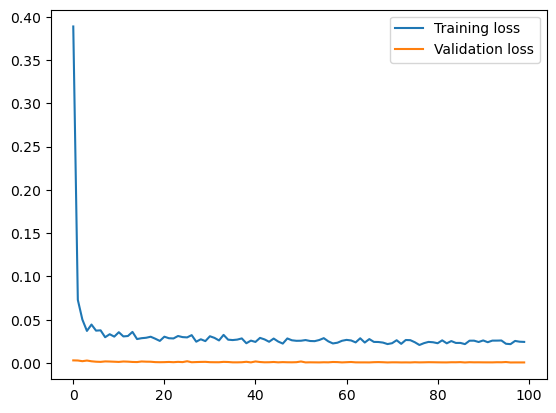

In [24]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 30 + 1
n_days_for_prediction=30

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) 

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 0s 105ms/step


C:\Users\L3b3l\AppData\Local\Temp\ipykernel_13772\1625216043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


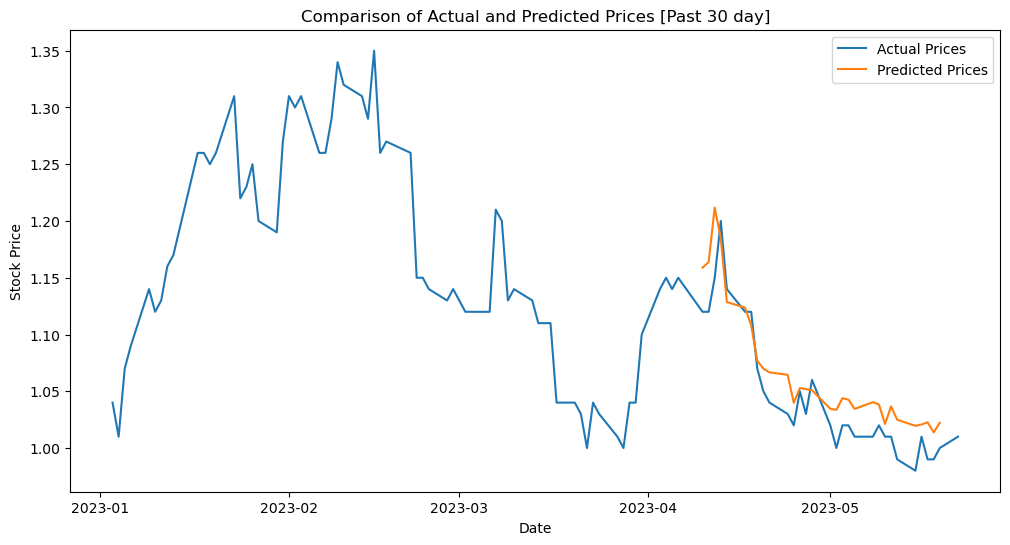

In [36]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-01-1']

#sns.lineplot(original['Date'], original['Open']).set(title='Predicticting the past 15 days')
#sns.lineplot(df_forecast['Date'],  df_forecast['Open'])
plt.figure(figsize=(12, 6))
plt.plot(original['Date'], original['Open'], label='Actual Prices')
plt.plot(df_forecast['Date'], df_forecast['Open'], label='Predicted Prices')
plt.title('Comparison of Actual and Predicted Prices [Past 30 day]')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [37]:
future_prediction= forecast_number

predict_period_dates = pd.date_range(list(train_dates)[-3], periods=future_prediction, freq='1d').tolist()

#Make prediction
prediction = model.predict(trainX[-future_prediction:]) 

forecast_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

2/2 [==============================] - 0s 55ms/step


In [38]:
forecast_dates2 = []
for time_i in predict_period_dates:
    forecast_dates2.append(time_i.date())
    
print('predict dates == {}.'.format(np.array(forecast_dates2).shape))   
print('y future == {}.'.format(y_pred_future.shape))  
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates2), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-12-1']


predict dates == (60,).
y future == (60,).


C:\Users\L3b3l\AppData\Local\Temp\ipykernel_13772\370819434.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


1/1 [==============================] - 0s 103ms/step
Mean Squared Error (MSE): 0.0008816553703587145
Mean Absolute Error (MAE): 0.025532544374465938
Model Accuracy: 90.8950824950254


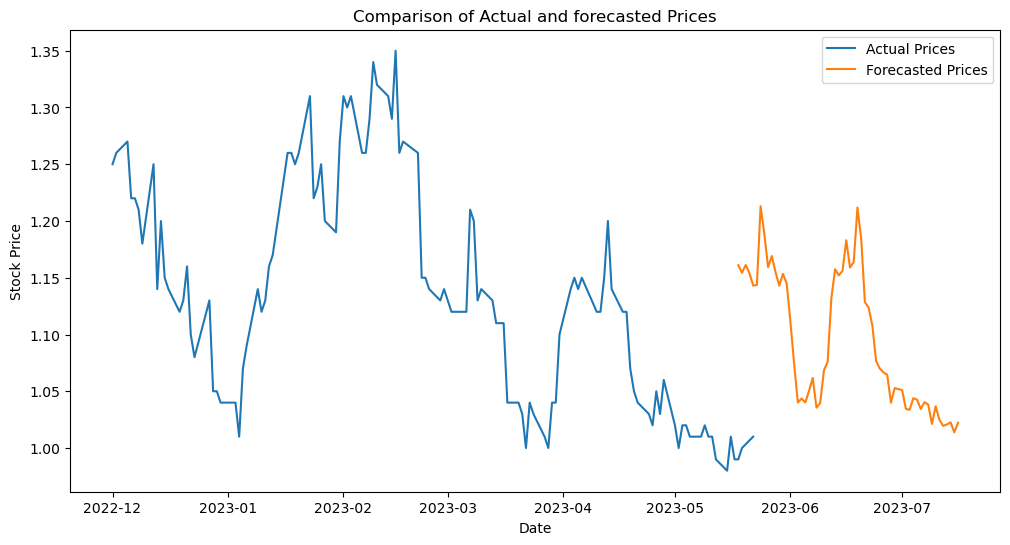

In [39]:
# Stock Price Prediction
prediction = model.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]


# Evaluation Metrics
mse = mean_squared_error(original['Open'].tail(forecast_number), df_forecast['Open'])
mae = mean_absolute_error(original['Open'].tail(forecast_number), df_forecast['Open'])

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

# Model Accuracy
accuracy = 100 * (1 - mse / np.var(original['Open']))
print('Model Accuracy:', accuracy)

# Comparison with Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(original['Date'], original['Open'], label='Actual Prices')
plt.plot(df_forecast['Date'], df_forecast['Open'], label='Forecasted Prices')
plt.title('Comparison of Actual and forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()